# Volatility Prediction in Financial Markets  - Model Notebook


# TODO:

#### Regression:
- Check scaling issue!!!! Seemingly ok
- Fix too large errrors -> param grid? Remove features? Check if computed correctly?
- 
- Check if lots of features in test data is NULL?

- Set up GradientBoostingRegressor


#### Neural net
- Sette opp Keras/pytorch Standard nettverk
- Sette opp Keras/pytorch LSTM nettverk


### Resultater:
- Laste opp alle test resultater til CFM page 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci




import datetime
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy import stats
import gc
%matplotlib inline


## Load the data

In [2]:
orig_train_X = pd.read_csv('data/training_input.csv', sep=';')
train_y = pd.read_csv('data/training_output.csv', sep=';')
orig_test_X  = pd.read_csv('data/testing_input.csv', sep=';')

In [3]:
gc.collect()

20

### Calculate number of and Impute missing values via interpolation

In [4]:
volatility_cols = [c for c in orig_train_X.columns if c.startswith('volatility')]
return_cols = [c for c in orig_train_X.columns if c.startswith('return')]
other_cols = ['date' , 'product_id']

In [5]:
train_X = orig_train_X.drop(orig_train_X[return_cols],axis=1)
train_R = orig_train_X.drop(orig_train_X[volatility_cols], axis=1)
test_X  = orig_test_X.drop(orig_test_X[return_cols], axis=1)
test_R  = orig_test_X.drop(orig_test_X[volatility_cols], axis=1)

Count nans and zeros i.e. no price change

In [6]:
train_num_NANs = pd.DataFrame({'ID': orig_train_X['ID'],'product_id': orig_train_X['product_id'],'num_NANs':(orig_train_X[volatility_cols].isnull()).sum(axis =1).astype(dtype = 'float64',copy=False)})
train_true_zeros = pd.DataFrame({'ID': orig_train_X['ID'],'product_id': orig_train_X['product_id'],'true_zeros': (orig_train_X[volatility_cols]==0).sum(axis =1).astype(dtype = 'float64',copy=False)})
test_num_NANs = pd.DataFrame({'ID': orig_test_X['ID'],'product_id': orig_test_X['product_id'],'num_NANs':(orig_test_X[volatility_cols].isnull()).sum(axis =1).astype(dtype = 'float64',copy=False)})
test_true_zeros = pd.DataFrame({'ID': orig_test_X['ID'],'product_id': orig_test_X['product_id'],'true_zeros': (orig_test_X[volatility_cols]==0).sum(axis =1).astype(dtype = 'float64',copy=False)})

We linearly interpolate the NaNs corresponding to volatilities and set NaN returns to 0 :

In [7]:
#Default interpolation direction is forward
train_X.iloc[:,3:] = train_X.iloc[:,3:].interpolate(axis=1)
test_X.iloc[:,3:]  = test_X.iloc[:,3:].interpolate(axis=1)

In [8]:
train_X.fillna(0, inplace=True) 
test_X.fillna(0, inplace=True) 

In [9]:
train_R.fillna(0, inplace=True) 
test_R.fillna(0, inplace=True) 

# Feature engineering

### Clustering

In [10]:
train_features =train_X.drop(train_X[volatility_cols],axis =1)
train_features['min_vol']    = np.min(train_X.iloc[:,3:], axis=1)
train_features['max_vol']    = np.max(train_X.iloc[:,3:], axis=1)
train_features['std_vol']    = np.std(train_X.iloc[:,3:], axis=1)
train_features['median_vol'] = np.median(train_X.iloc[:,3:], axis=1)
train_features['mean_vol'] = np.mean(train_X.iloc[:,3:], axis=1)
train_features['skew_vol'] = stats.skew(train_X.iloc[:,3:], axis=1)
train_features['kurtosis_vol'] = stats.kurtosis(train_X.iloc[:,3:], axis=1)
bin_length = 9
train_features['bin1_vol']  = np.mean(train_X.iloc[:,3:3+bin_length-1], axis=1)
train_features['bin2_vol']  = np.mean(train_X.iloc[:,3+bin_length:3+2*bin_length-1], axis=1)
train_features['bin3_vol']  = np.mean(train_X.iloc[:,3+2*bin_length:3+3*bin_length-1], axis=1)
train_features['bin4_vol']  = np.mean(train_X.iloc[:,3+3*bin_length:3+4*bin_length-1], axis=1)
train_features['bin5_vol']  = np.mean(train_X.iloc[:,3+4*bin_length:3+5*bin_length-1], axis=1)
train_features['bin6_vol']  = np.mean(train_X.iloc[:,3+5*bin_length:3+6*bin_length-1], axis=1)
#train_features['num_NANs'] =  train_num_NANs ## bytt ut med per produkt
#train_features['true_zeros'] =  train_true_zeros ## bytt ut med per produkt

###Differencing to account for ACF feature
train_features['lagged_diff_mean']= np.mean(np.diff(train_X.iloc[:,3:], axis=1),axis=1)
train_features['lagged_diff_std']= np.std(np.diff(train_X.iloc[:,3:], axis=1),axis=1)
train_features['lagged_diff_max']= np.max(np.diff(train_X.iloc[:,3:], axis=1),axis=1)
train_features['lagged_diff_min']= np.min(np.diff(train_X.iloc[:,3:], axis=1),axis=1)

### Date Spesific features####
date_mean = pd.DataFrame({'date': train_X['date'].unique(),'date_mean': np.array(train_X.groupby('date')[volatility_cols].mean().mean(axis=1))})
train_features = train_features.merge(date_mean,on='date',how = "left").set_index(train_features.index)

train_features = train_features.merge(train_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].mean(),on='date',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_mean_vol_date', 'volatility 13:50:00': '13:50_mean_vol_date','volatility 13:55:00':'13:55_mean_vol_date'}, inplace=True)

train_features = train_features.merge(train_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].std(),on='date',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_std_vol_date', 'volatility 13:50:00': '13:50_std_vol_date','volatility 13:55:00':'13:55_std_vol_date'}, inplace=True)

train_features = train_features.merge(train_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].max(),on='date',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_max_vol_date', 'volatility 13:50:00': '13:50_max_vol_date','volatility 13:55:00':'13:55_max_vol_date'}, inplace=True)

train_features = train_features.merge(train_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].min(),on='date',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_min_vol_date', 'volatility 13:50:00': '13:50_min_vol_date','volatility 13:55:00':'13:55_min_vol_date'}, inplace=True)

train_features = train_features.merge(train_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].skew(),on='date',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_skew_vol_date', 'volatility 13:50:00': '13:50_skew_vol_date','volatility 13:55:00':'13:55_skew_vol_date'}, inplace=True)

train_features = train_features.merge(train_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].apply(pd.DataFrame.kurt),on='date',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_kurt_vol_date', 'volatility 13:50:00': '13:50_kurt_vol_date','volatility 13:55:00':'13:55_kurt_vol_date'}, inplace=True)

# #### Product spesific features#####

product_mean = pd.DataFrame({'product_id': train_X['product_id'].unique(),'product_mean': np.array(train_X.groupby('product_id')[volatility_cols].mean().mean(axis=1))})
train_features = train_features.merge(product_mean,on='product_id',how = "left").set_index(train_features.index)

train_features = train_features.merge(train_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].mean(),on='product_id',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_mean_vol_stock', 'volatility 13:50:00': '13:50_mean_vol_stock','volatility 13:55:00':'13:55_mean_vol_stock'}, inplace=True)

train_features = train_features.merge(train_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].std(),on='product_id',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_std_vol_stock', 'volatility 13:50:00': '13:50_std_vol_stock','volatility 13:55:00':'13:55_std_vol_stock'}, inplace=True)

train_features = train_features.merge(train_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].max(),on='product_id',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_max_vol_stock', 'volatility 13:50:00': '13:50_max_vol_stock','volatility 13:55:00':'13:55_max_vol_stock'}, inplace=True)

train_features = train_features.merge(train_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].min(),on='product_id',how = "left").set_index(train_features.index)
train_features.rename(columns={'volatility 13:45:00': '13:45_min_vol_stock', 'volatility 13:50:00': '13:50_min_vol_stock','volatility 13:55:00':'13:55_min_vol_stock'}, inplace=True)

### Return features
train_features['ret_sign_std'] = np.var(train_R.iloc[:,3:], axis=1)
train_features['ret_sign_accum'] = np.sum(train_R.iloc[:,3:], axis=1)


#Merge clusters onto data frame
#train_features = train_features.merge(train_labels_pd, on='ID',how = "left").set_index(train_features.index)

#Merge zeros onto data frame
train_features = train_features.merge(train_num_NANs.drop(columns='product_id'), on='ID',how = "left").set_index(train_features.index)
train_features = train_features.merge(train_true_zeros.drop(columns='product_id'), on='ID',how = "left").set_index(train_features.index)

#train_features = train_features.merge(train_num_NANs.groupby('product_id')['num_NANs'].sum().to_frame(),on='product_id',how = "left").set_index(train_features.index)
#train_features = train_features.merge(train_true_zeros.groupby('product_id')['true_zeros'].sum().to_frame(),on='product_id',how = "left").set_index(train_features.index)



# Merge target onto data frame
train_features = train_features.merge(train_y, on='ID',how = "left").set_index(train_features.index)

train_features.fillna(0, inplace=True) 

##### Test features

In [11]:
test_features =test_X.drop(test_X[volatility_cols],axis =1)
test_features['min_vol']    = np.min(test_X.iloc[:,3:], axis=1)
test_features['max_vol']    = np.max(test_X.iloc[:,3:], axis=1)
test_features['std_vol']    = np.std(test_X.iloc[:,3:], axis=1)
test_features['median_vol'] = np.median(test_X.iloc[:,3:], axis=1)
test_features['mean_vol'] = np.mean(test_X.iloc[:,3:], axis=1)
test_features['skew_vol'] = stats.skew(test_X.iloc[:,3:], axis=1)
test_features['kurtosis_vol'] = stats.kurtosis(test_X.iloc[:,3:], axis=1)
bin_length = 9
test_features['bin1_vol']  = np.mean(test_X.iloc[:,3:3+bin_length-1], axis=1)
test_features['bin2_vol']  = np.mean(test_X.iloc[:,3+bin_length:3+2*bin_length-1], axis=1)
test_features['bin3_vol']  = np.mean(test_X.iloc[:,3+2*bin_length:3+3*bin_length-1], axis=1)
test_features['bin4_vol']  = np.mean(test_X.iloc[:,3+3*bin_length:3+4*bin_length-1], axis=1)
test_features['bin5_vol']  = np.mean(test_X.iloc[:,3+4*bin_length:3+5*bin_length-1], axis=1)
test_features['bin6_vol']  = np.mean(test_X.iloc[:,3+5*bin_length:3+6*bin_length-1], axis=1)
#test_features['num_NANs'] =  test_num_NANs ## bytt ut med per produkt
#test_features['true_zeros'] =  test_true_zeros ## bytt ut med per produkt

###Differencing to account for ACF feature
test_features['lagged_diff_mean']= np.mean(np.diff(test_X.iloc[:,3:], axis=1),axis=1)
test_features['lagged_diff_std']= np.std(np.diff(test_X.iloc[:,3:], axis=1),axis=1)
test_features['lagged_diff_max']= np.max(np.diff(test_X.iloc[:,3:], axis=1),axis=1)
test_features['lagged_diff_min']= np.min(np.diff(test_X.iloc[:,3:], axis=1),axis=1)

### Date Spesific features####
date_mean = pd.DataFrame({'date': test_X['date'].unique(),'date_mean': np.array(test_X.groupby('date')[volatility_cols].mean().mean(axis=1))})
test_features = test_features.merge(date_mean,on='date',how = "left").set_index(test_features.index)

test_features = test_features.merge(test_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].mean(),on='date',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_mean_vol_date', 'volatility 13:50:00': '13:50_mean_vol_date','volatility 13:55:00':'13:55_mean_vol_date'}, inplace=True)

test_features = test_features.merge(test_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].std(),on='date',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_std_vol_date', 'volatility 13:50:00': '13:50_std_vol_date','volatility 13:55:00':'13:55_std_vol_date'}, inplace=True)

test_features = test_features.merge(test_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].max(),on='date',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_max_vol_date', 'volatility 13:50:00': '13:50_max_vol_date','volatility 13:55:00':'13:55_max_vol_date'}, inplace=True)

test_features = test_features.merge(test_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].min(),on='date',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_min_vol_date', 'volatility 13:50:00': '13:50_min_vol_date','volatility 13:55:00':'13:55_min_vol_date'}, inplace=True)

test_features = test_features.merge(test_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].skew(),on='date',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_skew_vol_date', 'volatility 13:50:00': '13:50_skew_vol_date','volatility 13:55:00':'13:55_skew_vol_date'}, inplace=True)

test_features = test_features.merge(test_X.groupby('date')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].apply(pd.DataFrame.kurt),on='date',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_kurt_vol_date', 'volatility 13:50:00': '13:50_kurt_vol_date','volatility 13:55:00':'13:55_kurt_vol_date'}, inplace=True)

# #### Product spesific features#####

product_mean = pd.DataFrame({'product_id': test_X['product_id'].unique(),'product_mean': np.array(test_X.groupby('product_id')[volatility_cols].mean().mean(axis=1))})
test_features = test_features.merge(product_mean,on='product_id',how = "left").set_index(test_features.index)

test_features = test_features.merge(test_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].mean(),on='product_id',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_mean_vol_stock', 'volatility 13:50:00': '13:50_mean_vol_stock','volatility 13:55:00':'13:55_mean_vol_stock'}, inplace=True)

test_features = test_features.merge(test_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].std(),on='product_id',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_std_vol_stock', 'volatility 13:50:00': '13:50_std_vol_stock','volatility 13:55:00':'13:55_std_vol_stock'}, inplace=True)

test_features = test_features.merge(test_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].max(),on='product_id',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_max_vol_stock', 'volatility 13:50:00': '13:50_max_vol_stock','volatility 13:55:00':'13:55_max_vol_stock'}, inplace=True)

test_features = test_features.merge(test_X.groupby('product_id')['volatility 13:45:00','volatility 13:50:00','volatility 13:55:00'].min(),on='product_id',how = "left").set_index(test_features.index)
test_features.rename(columns={'volatility 13:45:00': '13:45_min_vol_stock', 'volatility 13:50:00': '13:50_min_vol_stock','volatility 13:55:00':'13:55_min_vol_stock'}, inplace=True)

### Return features
test_features['ret_sign_std'] = np.var(test_R.iloc[:,3:], axis=1)
test_features['ret_sign_accum'] = np.sum(test_R.iloc[:,3:], axis=1)


#Merge clusters onto data frame
#test_features = test_features.merge(test_labels_pd, on='ID',how = "left").set_index(test_features.index)

#Merge zeros onto data frame
test_features = test_features.merge(test_num_NANs.drop(columns='product_id'), on='ID',how = "left").set_index(test_features.index)
test_features = test_features.merge(test_true_zeros.drop(columns='product_id'), on='ID',how = "left").set_index(test_features.index)

#test_features = test_features.merge(test_num_NANs.groupby('product_id')['num_NANs'].sum().to_frame(),on='product_id',how = "left").set_index(test_features.index)
#test_features = test_features.merge(test_true_zeros.groupby('product_id')['true_zeros'].sum().to_frame(),on='product_id',how = "left").set_index(test_features.index)




test_features.fillna(0, inplace=True) 

## Train model

Define error function (mean average percent error)

In [12]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
def MAPE_per_obs(y_true, y_pred):
    return (np.abs((y_true - y_pred) / y_true)) * 100

Split training data in train and test sets

In [14]:
from sklearn.model_selection import train_test_split

#train_features = train_features.merge(train_y, on='ID')
#train_features.drop(['date', 'product_id'], axis=1, inplace=True)
#test_features.drop(['date', 'product_id'], axis=1, inplace=True)

##Split test train data in 80%/20%
train_X_, val_X_, train_y_, val_y_ = train_test_split(train_features.iloc[:,:-1], train_features['TARGET'],
                                                      test_size=0.2, random_state=32, stratify=train_features['product_id'])

train_X_['TARGET'] = train_y_
val_X_['TARGET'] = val_y_
regression_cols = train_features.columns[3:-1] ## Remove product_id, data and target
print("Number of features:",len(regression_cols))



Number of features: 53


### Provide benchmark models

In [15]:
train_pred_mean = train_X_[['mean_vol','TARGET']]
val_pred_mean = val_X_[['mean_vol','TARGET']]

print('Train error=', round(MAPE(train_features['TARGET'], train_features['mean_vol']), 4), '%')
print('Validation error =', round(MAPE(val_pred_mean['TARGET'], val_pred_mean['mean_vol']), 4), '%')

test_pred_mean = test_features[['ID','mean_vol']]
test_pred_mean = test_pred_mean.rename(columns = {'mean_vol':'TARGET'})
test_pred_mean.to_csv('results/mean_pred.csv', sep=';', index=False)

Train error= 36.9063 %
Validation error = 36.9016 %


In [16]:
train_pred_median = train_X_[['median_vol','TARGET']]
val_pred_median = val_X_[['median_vol','TARGET']]

print('Train error=', round(MAPE(train_features['TARGET'], train_features['median_vol']), 4), '%')
print('Validation error =', round(MAPE(val_pred_median['TARGET'], val_pred_median['median_vol']), 4), '%')
test_pred_median = test_features[['ID','median_vol']]
test_pred_median = test_pred_median.rename(columns = {'median_vol':'TARGET'})
test_pred_median.to_csv('results/median_pred.csv', sep=';', index=False)


Train error= 26.558 %
Validation error = 26.4845 %


### Nomalise data 

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


#scaler = RobustScaler(quantile_range=(40, 60))
#scaler = PowerTransformer(method = 'box-cox')
scaler = StandardScaler()
#scaler = MinMaxScaler()


train_X_norm = train_X_.copy()
val_X_norm = val_X_.copy()
train_features_norm =train_features.copy()
test_features_norm =test_features.copy()


#Scale train and validation data
transformer_validation = scaler.fit(train_X_[regression_cols])
train_X_norm[regression_cols] = transformer_validation.transform(train_X_norm[regression_cols])
val_X_norm[regression_cols] = transformer_validation.transform(val_X_norm[regression_cols])

#Scale train and test data
transformer = scaler.fit(train_features[regression_cols])
train_features_norm[regression_cols] = transformer.transform(train_features_norm[regression_cols])
test_features_norm[regression_cols] = transformer.transform(test_features_norm[regression_cols])

### Train Global models

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV



In [19]:
from sklearn.metrics import make_scorer
def score_function(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# wraps scoring functions for use in GridSearchCV and cross_val_score.
mape = make_scorer(score_function, greater_is_better=False)

In [20]:
grid = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(2,5),
    #'alpha': [0.00005,0.0001],
    #'l1_ratio': [0.1,0.3,0.5,0.7,0.9,1.0],
    'loss': ['squared_loss'],
    'max_iter': [10000000],
    'penalty': ['l2'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    #'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}
paramGrid = ParameterGrid(grid)


In [ ]:
huber_grid_elastic = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(4,7),
    #'alpha': [0.00005,0.0001],
    'l1_ratio': [0.1,0.3,0.5,0.7,.9,1.0],
    #'l1_ratio': [0.0],
    'loss': ['huber'],
    'max_iter': [10000000],
    'penalty': ['elasticnet'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    #'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}

huber_grid_l2 = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(4,7),
    #'alpha': [0.00005,0.0001],
    'l1_ratio': [0.1,0.3,0.5,0.7,.9,1.0],
    #'l1_ratio': [0.0],
    'loss': ['huber'],
    'max_iter': [10000000],
    'penalty': ['l2'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    #'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}

huber_grid_l1 = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(4,7),
    #'alpha': [0.00005,0.0001],
    'l1_ratio': [0.1,0.3,0.5,0.7,.9,1.0],
    #'l1_ratio': [0.0],
    'loss': ['huber'],
    'max_iter': [10000000],
    'penalty': ['l1'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    #'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}


squared_grid_elastic = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(4,7),
    #'alpha': [0.00005,0.0001],
    'l1_ratio': [0.1,0.3,0.5,0.7,.9,1.0],
    #'l1_ratio': [0.0],
    'loss': ['squared_loss'],
    'max_iter': [10000000],
    'penalty': ['elasticnet'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    #'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}

squared_grid_l2 = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(4,7),
    #'alpha': [0.00005,0.0001],
    'l1_ratio': [0.1,0.3,0.5,0.7,.9,1.0],
    #'l1_ratio': [0.0],
    'loss': ['squared_loss'],
    'max_iter': [10000000],
    'penalty': ['l2'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    #'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}

squared_grid_l1 = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    'alpha':10.0**-np.arange(4,7),
    #'alpha': [0.00005,0.0001],
    'l1_ratio': [0.1,0.3,0.5,0.7,.9,1.0],
    #'l1_ratio': [0.0],
    'loss': ['squared_loss'],
    'max_iter': [10000000],
    'penalty': ['l1'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    'epsilon': [0.0005,0.001,0.005,0.01,0.03,0.06],
    #'epsilon': [0.001,0.005,0.01,0.015],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}





In [ ]:
grids = [huber_grid_elastic, huber_grid_l2,huber_grid_l1,squared_grid_elastic,squared_grid_l2,squared_grid_l1]

In [ ]:
10.0**-4

In [ ]:

estimators = []
for grid in grids:

    model = SGDRegressor()
    grid = GridSearchCV(estimator=model, param_grid=grid,scoring=mape, n_jobs = -1, cv =5)
    grid_result = grid.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])

    best_model =grid_result.best_estimator_
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    estimators.append(best_model)
    
    


In [ ]:
model = SGDRegressor()
grid = GridSearchCV(estimator=model, param_grid=huber_grid_elastic,scoring=mape, n_jobs = -1, cv =5)
grid_result = grid.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])

best_model =grid_result.best_estimator_
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
plt.rc('xtick', labelsize=16) 

In [ ]:
i = 0

for best_model in estimators:
    feature_importance = pd.Series(index = regression_cols, data = np.abs(best_model.coef_))
    n_selected_features = (feature_importance>0).sum()
    print('{0:d} features, reduction of {1:2.2f}%'.format(
        n_selected_features,(1-n_selected_features/len(feature_importance))*100))
    fig = plt.figure(figsize = (18,6))
    feature_importance.sort_values().tail(30).plot(kind = 'bar')
    plt.tight_layout()
    plt.savefig('plots/coefs_model_'+str(i)+'.png', dpi = fig.dpi)
    plt.show()
    i = i+1

In [ ]:
fitted_models=[]
for best_model in estimators:
    fitted_model = best_model.fit(train_features_norm[regression_cols],train_features_norm['TARGET'])
    fitted_models.append(fitted_model)
    print('Train error SGD regressor =', round(MAPE(train_features_norm['TARGET'], np.maximum(fitted_model.predict(train_features_norm[regression_cols]),0)), 4), '%')

In [ ]:
print('Train error SGD regressor =', round(MAPE(train_features_norm['TARGET'], np.maximum(fitted_model.predict(train_features_norm[regression_cols]),0)), 4), '%')

In [ ]:
i = 0
for fitted_model in fitted_models:
    predictions = pd.DataFrame({'ID': test_features_norm['ID'],'TARGET': np.maximum(fitted_model.predict(test_features_norm[regression_cols]),0)})
    predictions.to_csv('results/global_SGD_regressor_'+str(i)+'.csv', sep=';', index=False)
    i = i+1

In [ ]:
i = 0
for fitted_model in fitted_models:
    joblib_file = 'fitted_models/joblib_model_'+str(i)+'.pkl'
    joblib.dump(fitted_model,joblib_file)
    i=i+1

In [24]:
from sklearn.externals import joblib

In [35]:
for i in range(0,6):
    loaded_model = joblib.load('fitted_models/joblib_model_'+str(i)+'.pkl')
    print('Train error SGD regressor =', MAPE(train_features_norm['TARGET'], np.maximum(loaded_model.predict(train_features_norm[regression_cols]),0)), '%')
    predictions = pd.DataFrame({'ID': test_features_norm['ID'],'TARGET': np.maximum(loaded_model.predict(test_features_norm[regression_cols]),0)})
    predictions.to_csv('results/global_SGD_regressor_v2_'+str(i)+'.csv', sep=';', index=False)

C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SGDRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train error SGD regressor = 22.969080424630135 %


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SGDRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train error SGD regressor = 23.325742343778664 %


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SGDRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train error SGD regressor = 24.35275673225673 %


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SGDRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train error SGD regressor = 27.532021966448468 %


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SGDRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train error SGD regressor = 32.69515225955074 %


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\base.py:253: UserWarning: Trying to unpickle estimator SGDRegressor from version 0.20.2 when using version 0.20.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Train error SGD regressor = 27.532021966448468 %


### Training local models

In [98]:
grid = {
    #'alpha':[0.00006, 0.00007, 0.00008, 0.00009, 0.00010, 0.00011, 0.00012, 0.00013], 
    #'alpha':10.0**-np.arange(2,5),
    'alpha': [0.00001,0.0001,0.0005,0.001],
    'l1_ratio': [0.05,0.1,0.3,0.5,0.7,.9,1.0],
    'loss': ['huber'],
    'max_iter': [10000000],
    'penalty': ['elasticnet'],
    'early_stopping': [False],
    'tol': [0.00000001],
    'fit_intercept':[True],
    'epsilon': [0.0001,0.0005,0.001,0.005,0.01,0.03],
    #'epsilon': [0.0001,0.001,0.005,0.01],
    'shuffle': [False],
    'learning_rate': ['optimal'],
    'eta0': [0.5],
    'power_t': [0.25],
    'n_iter_no_change': [5],
}


In [99]:
model = SGDRegressor()
grid = GridSearchCV(estimator=model, param_grid=grid,scoring=mape, n_jobs = -1, cv =5)

In [100]:
bestModels = []
bestScores = [] 
product_ids = train_X_norm['product_id'].unique()

train_pred = pd.DataFrame(columns=['ID','prediction'])
test_pred = pd.DataFrame(columns=['ID','TARGET'])

for product_id in product_ids:
#for product_id in range(1,10):
#for product_id in range(165,166):    

    df_slice_train = train_features_norm[train_features_norm['product_id'] == product_id]
    df_slice_test = test_features_norm[test_features_norm['product_id'] == product_id]
    grid_result = grid.fit(df_slice_train[regression_cols], df_slice_train['TARGET'])
    
    
    print("Product_id: ",product_id)
    print("MAPE Score: ",grid_result.best_score_)
    bestModels.append(grid_result.best_estimator_)
    bestScores.append(grid_result.best_score_)
    
    train_pred = train_pred.append(pd.DataFrame({'ID': df_slice_train['ID'],'prediction': np.maximum(grid_result.best_estimator_.predict(df_slice_train[regression_cols]),0.0)}))
    test_pred = test_pred.append(pd.DataFrame({'ID': df_slice_test['ID'],'TARGET': np.maximum(grid_result.best_estimator_.predict(df_slice_test[regression_cols]),0.0)}))   

    

C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  165
MAPE Score:  -22.1781429909937


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  225
MAPE Score:  -24.181835107009054


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  111
MAPE Score:  -24.49231417237781


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  16
MAPE Score:  -21.930098725219715


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  175
MAPE Score:  -22.351290705433456


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  19
MAPE Score:  -27.697363626784565


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  100
MAPE Score:  -20.80539757885346


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  253
MAPE Score:  -23.3352874246767


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  304
MAPE Score:  -22.250589548353947


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  239
MAPE Score:  -24.118689259851063


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  141
MAPE Score:  -21.45148994382464


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  309
MAPE Score:  -20.070548523104375


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  105
MAPE Score:  -24.565050754413296


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  46
MAPE Score:  -19.50177091242204


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  192
MAPE Score:  -22.99074633755445


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  51
MAPE Score:  -20.550861074727475


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  138
MAPE Score:  -24.56897544017006


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  77
MAPE Score:  -21.07402569012213


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  267
MAPE Score:  -23.59748088338967


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  82
MAPE Score:  -23.481637536914064


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  201
MAPE Score:  -19.982743914735153
Product_id:  310
MAPE Score:  -22.51089068820312


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  108
MAPE Score:  -21.657318006099153


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  72
MAPE Score:  -23.282481561855107


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  115
MAPE Score:  -23.99705450402712


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  133
MAPE Score:  -22.652935957785974


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  221
MAPE Score:  -20.41957002644177


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  47
MAPE Score:  -24.177893455197474


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  259
MAPE Score:  -21.734464282880083


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  281
MAPE Score:  -21.560889849509817


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  87
MAPE Score:  -19.922565328522094


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  237
MAPE Score:  -23.60569709403949


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  4
MAPE Score:  -21.576528663425524


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  42
MAPE Score:  -24.32226008823044


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  66
MAPE Score:  -21.351402545891784


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  205
MAPE Score:  -22.04410484008619


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  93
MAPE Score:  -20.84665619086866


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  130
MAPE Score:  -23.624268855729632


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  124
MAPE Score:  -22.269516096669797


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  76
MAPE Score:  -28.341158049738464


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  53
MAPE Score:  -23.242080867519118


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  157
MAPE Score:  -22.26918477636475


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  36
MAPE Score:  -20.740637143013114


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  195
MAPE Score:  -23.138069966454424


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  137
MAPE Score:  -23.67024996787295


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  256
MAPE Score:  -24.736040903164497


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  91
MAPE Score:  -21.021095484384215


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  268
MAPE Score:  -21.242449298232735


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  62
MAPE Score:  -21.244187332519232


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  150
MAPE Score:  -21.285056503914642


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  228
MAPE Score:  -22.407008476689494


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  29
MAPE Score:  -22.1606768540268


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  258
MAPE Score:  -21.026678400315923


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  12
MAPE Score:  -22.85651946281435


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  288
MAPE Score:  -20.650219052061043


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  298
MAPE Score:  -20.897436400323606


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  164
MAPE Score:  -20.31072671075


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  83
MAPE Score:  -21.762592290682143


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  142
MAPE Score:  -23.592751989586205
Product_id:  169
MAPE Score:  -21.126912528749024


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  90
MAPE Score:  -20.76613316994076


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  187
MAPE Score:  -26.700529421214732


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  30
MAPE Score:  -25.881893624133284
Product_id:  230
MAPE Score:  -29.0497899989595


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  21
MAPE Score:  -22.0927195089098


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  204
MAPE Score:  -22.00181219702753
Product_id:  233
MAPE Score:  -28.794453474900806


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  35
MAPE Score:  -21.287122638867537


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  23
MAPE Score:  -22.555633043941825


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  84
MAPE Score:  -20.28616581446604


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  273
MAPE Score:  -20.257623309216076


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  269
MAPE Score:  -21.245949509839395


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  166
MAPE Score:  -23.69501070060802


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  242
MAPE Score:  -23.96916578811914


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  191
MAPE Score:  -19.761187180085578


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  213
MAPE Score:  -21.310382838662356


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  58
MAPE Score:  -22.721846210057027


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  152
MAPE Score:  -21.698739840208745


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  79
MAPE Score:  -22.349139274260878


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  279
MAPE Score:  -23.107619927239167


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  297
MAPE Score:  -21.47770048993579


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  302
MAPE Score:  -23.731810207369424


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  260
MAPE Score:  -22.90485690764483


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  54
MAPE Score:  -23.287306507868347


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  188
MAPE Score:  -22.87996038278958


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  171
MAPE Score:  -20.556160923176666


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  274
MAPE Score:  -20.067171809517674


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  121
MAPE Score:  -22.43830734288717


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  52
MAPE Score:  -20.828074304172443


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  48
MAPE Score:  -26.306702998533467


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  94
MAPE Score:  -19.47903880086053


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  203
MAPE Score:  -26.311011573002833


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  113
MAPE Score:  -22.546334678329114


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  14
MAPE Score:  -21.692337964499465


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  9
MAPE Score:  -20.67044508532652


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  117
MAPE Score:  -28.241026653347745


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  26
MAPE Score:  -20.156305453220366


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  179
MAPE Score:  -21.945123700279417


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  13
MAPE Score:  -22.089456986816973
Product_id:  249
MAPE Score:  -29.172677847627114


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  78
MAPE Score:  -23.024746857977625


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  143
MAPE Score:  -20.55694907469057


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  168
MAPE Score:  -23.117787950720647


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  251
MAPE Score:  -22.409956435884958


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  136
MAPE Score:  -20.129082254441055


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  99
MAPE Score:  -21.99758703768934
Product_id:  226
MAPE Score:  -23.75870504835347


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  219
MAPE Score:  -21.887825219083965


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  208
MAPE Score:  -21.05704439267917


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  196
MAPE Score:  -24.14539875248575


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  38
MAPE Score:  -24.946373820632736


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  270
MAPE Score:  -24.05880879441912


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  22
MAPE Score:  -19.927372054887197


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  63
MAPE Score:  -22.785906864099736


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  28
MAPE Score:  -23.11344090470101


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  190
MAPE Score:  -21.620218054690728


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  126
MAPE Score:  -22.28910169918106


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  10
MAPE Score:  -21.87392112799758


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  125
MAPE Score:  -20.70569385937633


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  278
MAPE Score:  -25.424680610989103


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  240
MAPE Score:  -20.72994120604171


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  161
MAPE Score:  -21.458537442177697


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  67
MAPE Score:  -21.864156026017646


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  5
MAPE Score:  -23.221641516086862


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  7
MAPE Score:  -20.55265877629991


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  101
MAPE Score:  -20.73822460597972


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  59
MAPE Score:  -22.46522449888264


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  71
MAPE Score:  -22.752860386233444


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  223
MAPE Score:  -22.877933847582987


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  144
MAPE Score:  -21.3730963344568


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  96
MAPE Score:  -22.393724991024943


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  153
MAPE Score:  -22.77479976354134


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  313
MAPE Score:  -24.837283642532626


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  212
MAPE Score:  -23.057817773886782


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  131
MAPE Score:  -21.368180395610423


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  210
MAPE Score:  -21.301649043246417


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  39
MAPE Score:  -22.133354138945403


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  305
MAPE Score:  -20.348446408282737


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  252
MAPE Score:  -24.177094955617086


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  86
MAPE Score:  -25.339123979862308


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  24
MAPE Score:  -23.6728824191157


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  57
MAPE Score:  -21.402316832167905


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  307
MAPE Score:  -21.68587578625563


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  271
MAPE Score:  -22.24836644056075


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  172
MAPE Score:  -20.425097533315935


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  220
MAPE Score:  -22.754575249903276


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  200
MAPE Score:  -19.75542938365012


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  119
MAPE Score:  -23.07561583126142


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  241
MAPE Score:  -33.42712711200415


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  81
MAPE Score:  -23.2963808362873


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  110
MAPE Score:  -21.07375523516836


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  232
MAPE Score:  -23.313681935158513


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  75
MAPE Score:  -21.86637443376969


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  311
MAPE Score:  -20.671961580912363


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  92
MAPE Score:  -23.45280386990462


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  176
MAPE Score:  -22.214176365407102


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  234
MAPE Score:  -21.50431972902232


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  18
MAPE Score:  -23.254277151527376


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  155
MAPE Score:  -20.79313134620089


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  316
MAPE Score:  -21.779835396756347


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  60
MAPE Score:  -21.884545615987566


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  34
MAPE Score:  -29.031996506057656


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  246
MAPE Score:  -23.732202564080705


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  25
MAPE Score:  -20.266127931390262


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  129
MAPE Score:  -21.74154565101862


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  236
MAPE Score:  -24.461447003322874


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  222
MAPE Score:  -20.916576522847787


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  163
MAPE Score:  -23.248286714628073


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  287
MAPE Score:  -22.845462707112418


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  315
MAPE Score:  -21.246091351444957
Product_id:  264
MAPE Score:  -25.151685080775522


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  167
MAPE Score:  -21.856364984734462


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  41
MAPE Score:  -22.274511677831068


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  296
MAPE Score:  -24.618444307702273


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  314
MAPE Score:  -19.34105340147983


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  65
MAPE Score:  -23.711007968211575


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  198
MAPE Score:  -21.55255558377579


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  149
MAPE Score:  -20.950036748528436


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  235
MAPE Score:  -23.069938335685716


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  263
MAPE Score:  -20.14176119048275


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  55
MAPE Score:  -20.51418950421463


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  292
MAPE Score:  -23.391177028890674


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  280
MAPE Score:  -21.479815403850928


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  123
MAPE Score:  -21.9692557975681


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  140
MAPE Score:  -23.58622404683349


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  128
MAPE Score:  -22.898576082856206


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  197
MAPE Score:  -20.93108617746596


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  20
MAPE Score:  -23.620755787621345


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  32
MAPE Score:  -23.270640660060113


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  206
MAPE Score:  -21.404681058889235


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  244
MAPE Score:  -22.003183231738987


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  257
MAPE Score:  -20.653162240759602


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  132
MAPE Score:  -20.76743294762626
Product_id:  145
MAPE Score:  -20.489057811227575


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  207
MAPE Score:  -22.606051982811458


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  186
MAPE Score:  -21.292521820515095


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  88
MAPE Score:  -22.62726356808848


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  114
MAPE Score:  -21.121199720375426


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  218
MAPE Score:  -22.789245557796118
Product_id:  248
MAPE Score:  -24.784485758280198


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  97
MAPE Score:  -26.280894198678652


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  103
MAPE Score:  -21.131716546575923


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  193
MAPE Score:  -23.05587819784683


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  250
MAPE Score:  -19.813229643234603


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  265
MAPE Score:  -21.512957226367995


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  61
MAPE Score:  -20.023809196568227


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  289
MAPE Score:  -28.158271475898072


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  49
MAPE Score:  -23.49460369314385


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  180
MAPE Score:  -22.952052382588665


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  73
MAPE Score:  -22.04401896280124


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  243
MAPE Score:  -22.90449664057095


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  177
MAPE Score:  -25.853710539804464


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  151
MAPE Score:  -22.44966146702026


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  290
MAPE Score:  -21.680575075557403


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  178
MAPE Score:  -22.467090201459047


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  104
MAPE Score:  -21.91227817746412


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  308
MAPE Score:  -20.81483406421535


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  69
MAPE Score:  -21.18977435812882


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  189
MAPE Score:  -21.3362269238522


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  231
MAPE Score:  -20.881892317956574


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  74
MAPE Score:  -20.675760918027674


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  282
MAPE Score:  -19.826810701304712


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  3
MAPE Score:  -21.214302550792887


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  182
MAPE Score:  -20.081101550492146


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  247
MAPE Score:  -24.443032865166547


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  2
MAPE Score:  -21.356161666895137


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  148
MAPE Score:  -23.186028916938135


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  306
MAPE Score:  -21.72957505903925


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  85
MAPE Score:  -22.920297777482403


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  89
MAPE Score:  -21.20119628222948


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  37
MAPE Score:  -21.88705702928525


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  173
MAPE Score:  -19.635442363892988


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  185
MAPE Score:  -19.796578054393304


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  227
MAPE Score:  -21.559984516200338


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  98
MAPE Score:  -21.484991119562018


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  183
MAPE Score:  -21.124394025220898


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  17
MAPE Score:  -18.65086784188933


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  6
MAPE Score:  -21.04004648339758


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  181
MAPE Score:  -20.624758946270557


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  156
MAPE Score:  -23.08044294449767


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  64
MAPE Score:  -22.423109933909885


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  134
MAPE Score:  -24.534005798833775


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  8
MAPE Score:  -21.13475702676031


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  162
MAPE Score:  -23.728725804900794


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  170
MAPE Score:  -21.813474085913214


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  299
MAPE Score:  -22.45399280208309


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  44
MAPE Score:  -21.933495068561985


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  295
MAPE Score:  -25.712207009871516


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  154
MAPE Score:  -21.4328533664343


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  245
MAPE Score:  -31.124612664551048


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  11
MAPE Score:  -20.42184167830052


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  238
MAPE Score:  -24.50809410798328


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  15
MAPE Score:  -19.254122430279253


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  80
MAPE Score:  -22.176811873369015


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  272
MAPE Score:  -21.858920549727717


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  106
MAPE Score:  -21.356574666798476


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  174
MAPE Score:  -21.795327579796616


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  255
MAPE Score:  -19.7251717569569


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  202
MAPE Score:  -27.97642380035731


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  266
MAPE Score:  -21.16829366103121


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  68
MAPE Score:  -21.75547046389255


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  303
MAPE Score:  -22.40161376294848


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  158
MAPE Score:  -26.493929042969537


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  146
MAPE Score:  -24.16235449785471


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  40
MAPE Score:  -27.417338978845002


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  317
MAPE Score:  -41.50038822526017


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  254
MAPE Score:  -22.094096502218466


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  135
MAPE Score:  -21.302383107789062


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  199
MAPE Score:  -25.20215769271892


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  277
MAPE Score:  -20.835547236380037


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  109
MAPE Score:  -21.438111406913972


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  122
MAPE Score:  -23.555382604304


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  214
MAPE Score:  -19.68851124235304


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  312
MAPE Score:  -22.266520868601734


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  300
MAPE Score:  -24.003145023670797


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  120
MAPE Score:  -23.04131987943451


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  275
MAPE Score:  -21.556380903090215


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  216
MAPE Score:  -23.718381783793305


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  301
MAPE Score:  -22.59129707222933


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  224
MAPE Score:  -20.965664584163022


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  215
MAPE Score:  -21.031463843137477


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  286
MAPE Score:  -19.531773843637158


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  293
MAPE Score:  -27.113808705246367


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  31
MAPE Score:  -52.66332790955671


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  262
MAPE Score:  -19.24935522888602


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  102
MAPE Score:  -23.718864867792476


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  261
MAPE Score:  -19.768947052803117


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  294
MAPE Score:  -21.051954789086007


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  43
MAPE Score:  -21.59429981257786


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  285
MAPE Score:  -26.669742801287743


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  160
MAPE Score:  -20.877335306444532


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  107
MAPE Score:  -21.79047177712288


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  95
MAPE Score:  -20.385291829118557


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  283
MAPE Score:  -24.722942901006547
Product_id:  284
MAPE Score:  -22.424545184012604


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  50
MAPE Score:  -22.688411059575543


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  112
MAPE Score:  -19.729812262854935


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  211
MAPE Score:  -130.775107424657


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  33
MAPE Score:  -20.759777784466547


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  139
MAPE Score:  -24.135326507693755


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  56
MAPE Score:  -22.94439515881541


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  118
MAPE Score:  -21.63020568537484


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  1
MAPE Score:  -20.250667555707615


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  229
MAPE Score:  -20.801379771912234


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  116
MAPE Score:  -21.27214417976547


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  194
MAPE Score:  -24.547434591833877


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  209
MAPE Score:  -25.14351901922445


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  45
MAPE Score:  -22.743856375981373
Product_id:  217
MAPE Score:  -22.82855728100666


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  318
MAPE Score:  -22.21116789752279


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  147
MAPE Score:  -22.503006717164645


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  276
MAPE Score:  -21.317614094529688


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  291
MAPE Score:  -20.119367139759362


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  184
MAPE Score:  -23.713097587038053


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  159
MAPE Score:  -22.14631972876893


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  127
MAPE Score:  -22.172053371594888


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Product_id:  27
MAPE Score:  -21.099383031266587
Product_id:  70
MAPE Score:  -24.214383178883406


C:\Users\Bruker\Miniconda3\envs\gputest\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [102]:
train_pred['ID'] = train_pred['ID'].astype(np.int64)

Train error SGD regressor = 22.5878 %


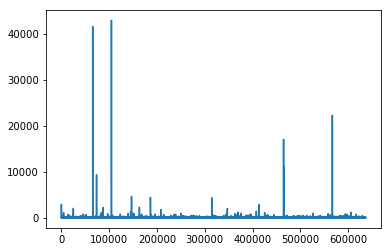

In [103]:
temp = train_features_norm.merge(train_pred,on='ID',how = "left").set_index(train_features_norm.index)
print('Train error SGD regressor =', round(MAPE(temp['TARGET'],temp['prediction']), 4), '%')
plt.plot(MAPE_per_obs(temp['TARGET'],temp['prediction']))

In [104]:
test_pred = test_pred.set_index('ID')
test_pred.loc[test_X['ID']].to_csv('results/local_SGD_regressor_new_last.csv', sep=';', index=True)

In [ ]:
epsilons = []
l1_ratios = []
alphas = []
for mod in bestModels:
    epsilons.append(mod.epsilon)
    l1_ratios.append(mod.l1_ratio)
    alphas.append(mod.alpha)

In [ ]:
plt.plot(bestScores)

In [ ]:
np.mean(bestScores)

In [ ]:
plt.hist(epsilons)

In [ ]:
plt.hist(alphas)

In [ ]:
plt.hist(l1_ratios)

##### Fit local models

### XGboost

In [ ]:
import xgboost

In [ ]:
def print_results(estimator,train_target,test_target,X_train,X_test,keras =False,preprocess_func=lambda x:x):
    score_train = score_function(train_target, estimator.predict(preprocess_func(X_train)))
    score_test = score_function(test_target, estimator.predict(preprocess_func(X_test)))
    if keras == False:
        print("best_params",estimator.best_params_)
    print("train: ", score_train)
    print("test: ", score_test)

In [ ]:
xgb = xgboost.XGBRegressor()
param_grid = {
    'max_depth': [2,4,6],
    'n_estimators': [50,100,200]
}

In [ ]:
xgb = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring=mape, n_jobs=-1)
%time xgb.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])



In [ ]:
print("Best: %f using %s" % (xgb.best_score_, xgb.best_params_))


In [ ]:
fig, ax = plt.subplots(figsize=(h, w))
xgboost.plot_importance(..., ax=ax)

In [ ]:
best_model =xgb.best_estimator_
fitted_model = best_model.fit(train_features_norm[regression_cols],train_features_norm['TARGET'])

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(20, 20))
plot_importance(xgb.best_estimator_,ax=ax)

In [ ]:
print('Train error SGD regressor =', round(MAPE(train_features_norm['TARGET'], np.maximum(fitted_model.predict(train_features_norm[regression_cols]),0)), 4), '%')

In [ ]:
predictions = pd.DataFrame({'ID': test_features_norm['ID'],'TARGET': np.maximum(fitted_model.predict(test_features_norm[regression_cols]),0)})
predictions.to_csv('results/global_XGB_regressor.csv', sep=';', index=False)

### Neural Net

In [159]:
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from sklearn.utils import parallel_backend
seed = 43

In [160]:
from keras import regularizers
from keras.utils import plot_model
import pydot
from keras.optimizers import SGD


In [161]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


Reduce to two layers with size 20, look at chollet book regarding LSTM, run on Microsoft Azure notebooks

In [162]:
##Define model
def custom_loss(y_true, y_pred):
    return K.mean(np.abs((y_true - y_pred) / y_true))* 100

def baseline_model(l1=30,l2=10, l3=5):
    model = Sequential()
    model.add(Dense(l1, name='Layer_1', input_dim=len(regression_cols), activation='relu',kernel_initializer='normal'))
    model.add(Dense(l2, name='Layer_2', activation='relu',kernel_initializer='normal'))
    model.add(Dense(l3, name='Layer_3', activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,name='Output',activation='relu',kernel_initializer='normal'))
   
    
    
    model.compile(loss=custom_loss,optimizer='Adagrad', metrics=[custom_loss])
    return model

In [25]:
##Define model
def custom_loss(y_true, y_pred):
    return K.mean(np.abs((y_true - y_pred) / y_true))* 100

def baseline_model(l1=100,l2=10):
    model = Sequential()
    model.add(Dense(l1, name='Layer_1', input_dim=len(regression_cols), activation='relu',kernel_initializer='he_normal'))
    model.add(Dense(l2, name='Layer_2', activation='relu',kernel_initializer='he_normal'))
    model.add(Dense(1,name='Output',activation='relu',kernel_initializer='he_normal'))   
    
    
    model.compile(loss=custom_loss,optimizer='Adagrad', metrics=[custom_loss])
    return model

<function __main__.baseline_model(l1=100, l2=10)>

In [163]:
from keras.utils import plot_model
plot_model(test_model, to_file='plots\model.png',show_shapes = True,show_layer_names =True) 

NameError: name 'test_model' is not defined

In [43]:
test_model._layers

In [23]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=1000, verbose=True)
#filepath="results\weights\weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callbacks_list = [checkpoint]

In [ ]:
estimator.fit(train_features_norm[regression_cols], train_features_norm['TARGET'], callbacks=callbacks_list)

In [164]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=20, batch_size=5000,verbose=True)
l1 =[50,30,20]
l2 = [20,10,5]
l3 = [10,5,3]

#l1= [30]
#l2=[10]
#param_grid = dict(l1=l1,l2=l2,l3=l3)
param_grid = dict(l1=l1,l2=l2,l3=l3)
grid = GridSearchCV(estimator=estimator, param_grid=param_grid,scoring=mape, n_jobs = 1, cv =5,return_train_score=True)
grid_result = grid.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Epoch 1/20
509050/509050 [==============================] - 3s 6us/step - loss: 26.9381 - custom_loss: 26.9381
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.3235 - custom_loss: 22.3235
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0205 - custom_loss: 22.0205
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8876 - custom_loss: 21.8876
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8196 - custom_loss: 21.8196
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7399 - custom_loss: 21.7399
Epoch 7/20
509050/509050 [==============================] - 2s 3us/step - loss: 21.6998 - custom_loss: 21.6998
Epoch 8/20
509050/509050 [==============================] - 2s 3us/step - loss: 21.6680 - custom_loss: 21.6680
Epoch 9/20
509050/509050 [==============================] - 2s 3us/step - loss: 21.6427 - custom_loss: 21.6427
E

509051/509051 [==============================] - 1s 2us/step - loss: 21.6915 - custom_loss: 21.6915
Epoch 11/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6711 - custom_loss: 21.6711
Epoch 12/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.6336 - custom_loss: 21.6336
Epoch 13/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.6010 - custom_loss: 21.6010
Epoch 14/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.5954 - custom_loss: 21.5954
Epoch 15/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.5623 - custom_loss: 21.5623
Epoch 16/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.5367 - custom_loss: 21.5367
Epoch 17/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.5282 - custom_loss: 21.5282
Epoch 18/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.5133 - custom_loss: 21.5133
Epoc

Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6377 - custom_loss: 21.6377
Epoch 20/20
509050/509050 [==============================] - 0s 1us/step
Epoch 1/20
509050/509050 [==============================] - 3s 7us/step - loss: 27.0050 - custom_loss: 27.0050
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.5929 - custom_loss: 22.5929
Epoch 3/20
509050/509050 [==============================] - 1s 2us/step - loss: 22.2914 - custom_loss: 22.2914
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1362 - custom_loss: 22.1362
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0274 - custom_loss: 22.0274
Epoch 6/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.9697 - custom_loss: 21.9697
Epoch 7/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.9370 - custom_loss: 21.9370
Epoch 8/20
509050/509050 [============

509050/509050 [==============================] - 1s 2us/step - loss: 21.9017 - custom_loss: 21.9017
Epoch 6/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.8292 - custom_loss: 21.8292
Epoch 7/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.7786 - custom_loss: 21.7786
Epoch 8/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.7596 - custom_loss: 21.7596
Epoch 9/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.7065 - custom_loss: 21.7065
Epoch 10/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.6801 - custom_loss: 21.6801
Epoch 11/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.6594 - custom_loss: 21.6594
Epoch 12/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.6258 - custom_loss: 21.6258
Epoch 13/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.6162 - custom_loss: 21.6162
Epoch 14

509051/509051 [==============================] - 1s 2us/step - loss: 21.7330 - custom_loss: 21.7330
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6981 - custom_loss: 21.6981
Epoch 16/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6828 - custom_loss: 21.6828
Epoch 17/20
509051/509051 [==============================] - 1s 2us/step - loss: 21.6545 - custom_loss: 21.6545
Epoch 18/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6401 - custom_loss: 21.6401
Epoch 19/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6187 - custom_loss: 21.6187
Epoch 20/20
509051/509051 [==============================] - 0s 1us/step
Epoch 1/20
509051/509051 [==============================] - 4s 7us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 2/20
509051/509051 [==============================] - 1s 2us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 3/20
509051/509051 [===============

509050/509050 [==============================] - 4s 7us/step - loss: 27.5646 - custom_loss: 27.5646
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.6429 - custom_loss: 22.6429
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.3128 - custom_loss: 22.3128
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1632 - custom_loss: 22.1632A: 0s - loss: 22.1441 - custom
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0592 - custom_loss: 22.0592
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9677 - custom_loss: 21.9677
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9313 - custom_loss: 21.9313
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8704 - custom_loss: 21.8704
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8663 - cus

509050/509050 [==============================] - 1s 3us/step - loss: 21.6781 - custom_loss: 21.6781
Epoch 11/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.6653 - custom_loss: 21.6653
Epoch 12/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.6447 - custom_loss: 21.6447
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6250 - custom_loss: 21.6250A: 0s - loss: 21.5261 - custom_lo
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6105 - custom_loss: 21.6105
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5996 - custom_loss: 21.5996
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5915 - custom_loss: 21.5915
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5730 - custom_loss: 21.5730
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21

509051/509051 [==============================] - 1s 3us/step - loss: 21.6681 - custom_loss: 21.6681
Epoch 19/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6490 - custom_loss: 21.6490
Epoch 20/20
509051/509051 [==============================] - 0s 1us/step
Epoch 1/20
509051/509051 [==============================] - 4s 8us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 2/20
509051/509051 [==============================] - 1s 2us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 3/20
509051/509051 [==============================] - 1s 2us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 4/20
509051/509051 [==============================] - 1s 2us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 5/20
509051/509051 [==============================] - 1s 2us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 6/20
509051/509051 [==============================] - 1s 2us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 7/20
509051/509051 [===========

509050/509050 [==============================] - 1s 3us/step - loss: 22.1690 - custom_loss: 22.1690
Epoch 5/20
509050/509050 [==============================] - 1s 2us/step - loss: 22.0779 - custom_loss: 22.0779
Epoch 6/20
509050/509050 [==============================] - 1s 2us/step - loss: 22.0266 - custom_loss: 22.0266
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9646 - custom_loss: 21.9646
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9126 - custom_loss: 21.9126
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8742 - custom_loss: 21.8742
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8522 - custom_loss: 21.8522A: 0s - loss: 21.8911 - custom_lo
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8061 - custom_loss: 21.8061
Epoch 12/20
509050/509050 [==============================] - 1s 2us/step - loss: 21.7926

509050/509050 [==============================] - 1s 3us/step - loss: 21.6465 - custom_loss: 21.6465
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6331 - custom_loss: 21.6331
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6114 - custom_loss: 21.6114
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5988 - custom_loss: 21.5988
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5907 - custom_loss: 21.5907
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5710 - custom_loss: 21.5710
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.5578 - custom_loss: 21.5578
Epoch 20/20
509050/509050 [==============================] - 0s 1us/step
Epoch 1/20
509050/509050 [==============================] - 4s 8us/step - loss: 27.4857 - custom_loss: 27.4857
Epoch 2/20
509050/509050 [==================

509051/509051 [==============================] - 0s 1us/step
Epoch 1/20
509051/509051 [==============================] - 4s 8us/step - loss: 28.2593 - custom_loss: 28.2593
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.3697 - custom_loss: 22.3697
Epoch 3/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0880 - custom_loss: 22.0880
Epoch 4/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9467 - custom_loss: 21.9467
Epoch 5/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8923 - custom_loss: 21.8923
Epoch 6/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8638 - custom_loss: 21.8638
Epoch 7/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8163 - custom_loss: 21.8163
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7887 - custom_loss: 21.7887
Epoch 9/20
509051/509051 [=========================

509050/509050 [==============================] - 1s 3us/step - loss: 21.9345 - custom_loss: 21.9345
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9105 - custom_loss: 21.9105
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8783 - custom_loss: 21.8783
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8569 - custom_loss: 21.8569
Epoch 12/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8379 - custom_loss: 21.8379
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8248 - custom_loss: 21.8248
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7950 - custom_loss: 21.7950
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7854 - custom_loss: 21.7854
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7674 - custom_loss: 21.7674
Epoch

509050/509050 [==============================] - 1s 3us/step - loss: 21.8020 - custom_loss: 21.8020
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7806 - custom_loss: 21.7806
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7804 - custom_loss: 21.7804
Epoch 20/20
509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [==============================] - 5s 9us/step - loss: 29.7272 - custom_loss: 29.7272
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.8169 - custom_loss: 22.8169
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.4523 - custom_loss: 22.4523
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2854 - custom_loss: 22.2854
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2027 - custom_loss: 22.2027
Epoch 6/20
509050/509050 [======================

509051/509051 [==============================] - 1s 3us/step - loss: 22.3049 - custom_loss: 22.3049
Epoch 5/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.2028 - custom_loss: 22.2028
Epoch 6/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1238 - custom_loss: 22.1238
Epoch 7/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0642 - custom_loss: 22.0642
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0058 - custom_loss: 22.0058
Epoch 9/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9656 - custom_loss: 21.9656
Epoch 10/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9301 - custom_loss: 21.9301
Epoch 11/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8956 - custom_loss: 21.8956
Epoch 12/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8653 - custom_loss: 21.8653
Epoch 13/

509050/509050 [==============================] - 1s 3us/step - loss: 21.7696 - custom_loss: 21.7696A: 0s - loss: 21.7551 - custom_loss: 
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7471 - custom_loss: 21.7471
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7270 - custom_loss: 21.7270
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7030 - custom_loss: 21.7030
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6804 - custom_loss: 21.6804
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6762 - custom_loss: 21.6762
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6593 - custom_loss: 21.6593
Epoch 20/20
509050/509050 [==============================] - 0s 1us/step
Epoch 1/20
509051/509051 [==============================] - 5s 9us/step - loss: 27.4054 - custom_loss: 27.4054
Epoch 2

509050/509050 [==============================] - 5s 9us/step - loss: 28.4933 - custom_loss: 28.4933
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.6519 - custom_loss: 22.6519
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.3352 - custom_loss: 22.3352
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1684 - custom_loss: 22.1684
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0842 - custom_loss: 22.0842
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9892 - custom_loss: 21.9892
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9672 - custom_loss: 21.9672
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9259 - custom_loss: 21.9259
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8788 - custom_loss: 21.8788
Epoch 10/20


509051/509051 [==============================] - 1s 3us/step - loss: 21.8002 - custom_loss: 21.8002
Epoch 11/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7798 - custom_loss: 21.7798
Epoch 12/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7506 - custom_loss: 21.7506
Epoch 13/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7457 - custom_loss: 21.7457
Epoch 14/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7139 - custom_loss: 21.7139
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7063 - custom_loss: 21.7063
Epoch 16/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6891 - custom_loss: 21.6891
Epoch 17/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6858 - custom_loss: 21.6858
Epoch 18/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6643 - custom_loss: 21.6643
Epoc

509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509051/509051 [==============================] - 5s 10us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 3/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 4/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 5/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 6/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 7/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 9/20
509051/509051 [========

509050/509050 [==============================] - 1s 3us/step - loss: 21.9519 - custom_loss: 21.9519
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9175 - custom_loss: 21.9175
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8820 - custom_loss: 21.8820
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8282 - custom_loss: 21.8282
Epoch 12/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8120 - custom_loss: 21.8120
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7660 - custom_loss: 21.7660
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7662 - custom_loss: 21.7662
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7411 - custom_loss: 21.7411
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7062 - custom_loss: 21.7062
Epoch

509051/509051 [==============================] - 1s 3us/step - loss: 21.6247 - custom_loss: 21.6247
Epoch 19/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6145 - custom_loss: 21.6145
Epoch 20/20
509051/509051 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [==============================] - 5s 11us/step - loss: 28.2013 - custom_loss: 28.2013
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.4232 - custom_loss: 22.4232
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0934 - custom_loss: 22.0934
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9374 - custom_loss: 21.9374
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8531 - custom_loss: 21.8531
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8041 - custom_loss: 21.8041
Epoch 7/20
509050/509050 [======================

509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 9/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 10/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 11/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 12/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 13/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 14/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_loss: 100.0000
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 100.0000 - custom_los

509050/509050 [==============================] - 1s 3us/step - loss: 21.7669 - custom_loss: 21.7669
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7652 - custom_loss: 21.7652
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7430 - custom_loss: 21.7430
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7272 - custom_loss: 21.7272
Epoch 20/20
509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [==============================] - 6s 11us/step - loss: 28.4164 - custom_loss: 28.4164
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.7194 - custom_loss: 22.7194
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.4522 - custom_loss: 22.4522
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.3340 - custom_loss: 22.3340
Epoch 5/20
509050/509050 [====================

509050/509050 [==============================] - 1s 3us/step - loss: 22.1482 - custom_loss: 22.1482
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0910 - custom_loss: 22.0910
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0121 - custom_loss: 22.0121
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9889 - custom_loss: 21.9889
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9401 - custom_loss: 21.9401
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9003 - custom_loss: 21.9003
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8762 - custom_loss: 21.8762
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8423 - custom_loss: 21.8423
Epoch 12/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8128 - custom_loss: 21.8128
Epoch 13/

509051/509051 [==============================] - 1s 3us/step - loss: 21.8854 - custom_loss: 21.8854
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8650 - custom_loss: 21.8650
Epoch 16/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8520 - custom_loss: 21.8520
Epoch 17/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8450 - custom_loss: 21.8450
Epoch 18/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8298 - custom_loss: 21.8298
Epoch 19/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8232 - custom_loss: 21.8232
Epoch 20/20
509051/509051 [==============================] - 1s 1us/step
Epoch 1/20
509051/509051 [==============================] - 6s 11us/step - loss: 27.5906 - custom_loss: 27.5906
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.5217 - custom_loss: 22.5217
Epoch 3/20
509051/509051 [==================

509050/509050 [==============================] - 1s 3us/step - loss: 22.3506 - custom_loss: 22.3506
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2266 - custom_loss: 22.2266
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1289 - custom_loss: 22.1289
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0787 - custom_loss: 22.0787
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0304 - custom_loss: 22.0304
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9797 - custom_loss: 21.9797
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9649 - custom_loss: 21.9649
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9323 - custom_loss: 21.9323
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9045 - custom_loss: 21.9045
Epoch 12/2

509050/509050 [==============================] - 1s 3us/step - loss: 21.7790 - custom_loss: 21.7790
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7696 - custom_loss: 21.7696
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7471 - custom_loss: 21.7471
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7351 - custom_loss: 21.7351
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7171 - custom_loss: 21.7171
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7116 - custom_loss: 21.7116
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6941 - custom_loss: 21.6941
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.6882 - custom_loss: 21.6882
Epoch 20/20
509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [=================

509051/509051 [==============================] - 1s 1us/step
Epoch 1/20
509051/509051 [==============================] - 6s 12us/step - loss: 28.8577 - custom_loss: 28.8577
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.6686 - custom_loss: 22.6686
Epoch 3/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.3327 - custom_loss: 22.3327
Epoch 4/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1927 - custom_loss: 22.1927
Epoch 5/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1406 - custom_loss: 22.1406
Epoch 6/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0788 - custom_loss: 22.0788
Epoch 7/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0265 - custom_loss: 22.0265
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9856 - custom_loss: 21.9856
Epoch 9/20
509051/509051 [========================

509050/509050 [==============================] - 1s 3us/step - loss: 22.0015 - custom_loss: 22.0015
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9916 - custom_loss: 21.9916
Epoch 12/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9589 - custom_loss: 21.9589
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9361 - custom_loss: 21.9361
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9193 - custom_loss: 21.9193
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9180 - custom_loss: 21.9180
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8917 - custom_loss: 21.8917
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8805 - custom_loss: 21.8805
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8661 - custom_loss: 21.8661
Epoc

509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [==============================] - 6s 12us/step - loss: 28.2949 - custom_loss: 28.2949
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.7837 - custom_loss: 22.7837
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.4221 - custom_loss: 22.4221
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2502 - custom_loss: 22.2502
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1740 - custom_loss: 22.1740
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1143 - custom_loss: 22.1143
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0513 - custom_loss: 22.0513
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0340 - custom_loss: 22.0340
Epoch 9/20
509050/509050 [========================

509051/509051 [==============================] - 1s 3us/step - loss: 21.9186 - custom_loss: 21.9186
Epoch 10/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8930 - custom_loss: 21.8930
Epoch 11/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8658 - custom_loss: 21.8658
Epoch 12/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8472 - custom_loss: 21.8472
Epoch 13/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8264 - custom_loss: 21.8264
Epoch 14/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8107 - custom_loss: 21.8107
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7977 - custom_loss: 21.7977
Epoch 16/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7874 - custom_loss: 21.7874
Epoch 17/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7651 - custom_loss: 21.7651
Epoc

509050/509050 [==============================] - 1s 3us/step - loss: 21.8644 - custom_loss: 21.8644
Epoch 20/20
509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509051/509051 [==============================] - 6s 12us/step - loss: 30.5788 - custom_loss: 30.5788
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 23.0002 - custom_loss: 23.0002
Epoch 3/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.5211 - custom_loss: 22.5211
Epoch 4/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.3651 - custom_loss: 22.3651
Epoch 5/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.2417 - custom_loss: 22.2417
Epoch 6/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1758 - custom_loss: 22.1758
Epoch 7/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1379 - custom_loss: 22.1379
Epoch 8/20
509051/509051 [=======================

509050/509050 [==============================] - 1s 3us/step - loss: 22.0891 - custom_loss: 22.0891
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0477 - custom_loss: 22.0477
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0160 - custom_loss: 22.0160A: 1s - loss: 22.1214
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9902 - custom_loss: 21.9902
Epoch 12/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9533 - custom_loss: 21.9533
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9364 - custom_loss: 21.9364
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9226 - custom_loss: 21.9226
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8950 - custom_loss: 21.8950
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8657 - custo

Epoch 18/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.7120 - custom_loss: 21.7120
Epoch 19/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.6995 - custom_loss: 21.6995
Epoch 20/20
509051/509051 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [==============================] - 7s 13us/step - loss: 29.0494 - custom_loss: 29.0494
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.5605 - custom_loss: 22.5605
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.1762 - custom_loss: 22.1762
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0237 - custom_loss: 22.0237
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9156 - custom_loss: 21.9156
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8603 - custom_loss: 21.8603
Epoch 7/20
509050/509050 [==========

509051/509051 [==============================] - 1s 3us/step - loss: 22.0210 - custom_loss: 22.0210
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9860 - custom_loss: 21.9860
Epoch 9/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9616 - custom_loss: 21.9616
Epoch 10/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9534 - custom_loss: 21.9534
Epoch 11/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9335 - custom_loss: 21.9335
Epoch 12/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9123 - custom_loss: 21.9123
Epoch 13/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9120 - custom_loss: 21.9120
Epoch 14/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8887 - custom_loss: 21.8887
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.8843 - custom_loss: 21.8843
Epoch 

509050/509050 [==============================] - 1s 3us/step - loss: 21.8845 - custom_loss: 21.8845
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8738 - custom_loss: 21.8738
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8641 - custom_loss: 21.8641A: 1s - loss: 21.9297 - c
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8554 - custom_loss: 21.8554
Epoch 20/20
509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [==============================] - 7s 14us/step - loss: 31.2544 - custom_loss: 31.2544
Epoch 2/20
509050/509050 [==============================] - 1s 3us/step - loss: 23.4098 - custom_loss: 23.4098
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.7308 - custom_loss: 22.7308
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.5014 - custom_loss: 22.5014
Epoch 5/20
509050/509

509050/509050 [==============================] - 1s 3us/step - loss: 22.0776 - custom_loss: 22.0776
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.0333 - custom_loss: 22.0333
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9722 - custom_loss: 21.9722
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9258 - custom_loss: 21.9258
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.9057 - custom_loss: 21.9057
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8684 - custom_loss: 21.8684
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8570 - custom_loss: 21.8570
Epoch 11/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8429 - custom_loss: 21.8429
Epoch 12/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8128 - custom_loss: 21.8128
Epoch 13/

509051/509051 [==============================] - 1s 3us/step - loss: 21.9901 - custom_loss: 21.9901
Epoch 15/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0037 - custom_loss: 22.0037
Epoch 16/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9845 - custom_loss: 21.9845
Epoch 17/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9721 - custom_loss: 21.9721
Epoch 18/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9599 - custom_loss: 21.9599
Epoch 19/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9545 - custom_loss: 21.9545
Epoch 20/20
509051/509051 [==============================] - 1s 1us/step
Epoch 1/20
509051/509051 [==============================] - 8s 15us/step - loss: 29.0111 - custom_loss: 29.0111
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 23.0982 - custom_loss: 23.0982
Epoch 3/20
509051/509051 [==================

509050/509050 [==============================] - 1s 3us/step - loss: 23.3324 - custom_loss: 23.3324
Epoch 3/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.7401 - custom_loss: 22.7401
Epoch 4/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.5358 - custom_loss: 22.5358
Epoch 5/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.4169 - custom_loss: 22.4169
Epoch 6/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.3505 - custom_loss: 22.3505
Epoch 7/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.3036 - custom_loss: 22.3036
Epoch 8/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2740 - custom_loss: 22.2740
Epoch 9/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2367 - custom_loss: 22.2367
Epoch 10/20
509050/509050 [==============================] - 1s 3us/step - loss: 22.2172 - custom_loss: 22.2172
Epoch 11/20

509050/509050 [==============================] - 1s 3us/step - loss: 21.8220 - custom_loss: 21.8220
Epoch 13/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.8024 - custom_loss: 21.8024
Epoch 14/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7871 - custom_loss: 21.7871
Epoch 15/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7810 - custom_loss: 21.7810
Epoch 16/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7654 - custom_loss: 21.7654
Epoch 17/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7570 - custom_loss: 21.7570
Epoch 18/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7451 - custom_loss: 21.7451
Epoch 19/20
509050/509050 [==============================] - 1s 3us/step - loss: 21.7389 - custom_loss: 21.7389
Epoch 20/20
509050/509050 [==============================] - 1s 1us/step
Epoch 1/20
509050/509050 [=================

509051/509051 [==============================] - 1s 1us/step
Epoch 1/20
509051/509051 [==============================] - 8s 15us/step - loss: 31.7154 - custom_loss: 31.7154
Epoch 2/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.7273 - custom_loss: 22.7273
Epoch 3/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.3408 - custom_loss: 22.3408
Epoch 4/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1946 - custom_loss: 22.1946
Epoch 5/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.1122 - custom_loss: 22.1122
Epoch 6/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0718 - custom_loss: 22.0718
Epoch 7/20
509051/509051 [==============================] - 1s 3us/step - loss: 22.0313 - custom_loss: 22.0313
Epoch 8/20
509051/509051 [==============================] - 1s 3us/step - loss: 21.9898 - custom_loss: 21.9898
Epoch 9/20
509051/509051 [========================

In [81]:
grid_result.cv_results_

{'mean_fit_time': array([ 57.17476821,  57.05585666,  58.27921033,  58.96767173,
         60.180862  ,  61.47483582,  62.25824957,  63.98778634,
         64.25101714,  65.13248897,  66.02653899,  66.92276254,
         69.73062449,  73.65456781,  71.84211626,  73.23666511,
         75.50566111,  76.16304107,  77.29354024,  78.73665586,
         80.03425112,  80.17195835,  83.93617787,  87.63533683,
         93.07218661, 102.65653987,  95.16607018]),
 'std_fit_time': array([0.78406912, 0.78343091, 0.63918732, 0.58844964, 0.48988725,
        0.53436704, 0.54480146, 1.27612233, 0.3521787 , 0.62756889,
        0.30519971, 0.50232369, 1.28613341, 3.44054004, 0.5706255 ,
        0.96602286, 0.86130703, 0.69689873, 1.0069379 , 1.62779163,
        1.01431103, 0.34247073, 2.47855289, 1.83444802, 1.47468332,
        3.21650189, 3.25640273]),
 'mean_score_time': array([ 5.69631777,  5.75827622,  5.98729873,  6.26571245,  6.39772458,
         6.48857126,  6.90152683,  6.85735435,  7.03444414,  7.25

In [45]:
 test_est = KerasRegressor(build_fn=baseline_model(10,10), epochs=20, batch_size=5000,verbose=True)

In [165]:
nn_train_prediction =np.maximum(grid_result.best_estimator_.predict(train_features_norm[regression_cols]),0.0)
print('score train: ', score_function(train_features_norm['TARGET'], nn_train_prediction))

nn_test_prediction=np.maximum(grid_result.best_estimator_.predict(test_features_norm[regression_cols]),0.0)

636313/636313 [==============================] - 3s 5us/step
score train:  21.553946903960014
635397/635397 [==============================] - 1s 1us/step


In [70]:
test_est = KerasRegressor(build_fn=baseline_model, epochs=20, batch_size=5000,verbose=True, l1=10, l2=10)
test_est.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])
    

Epoch 1/20
636313/636313 [==============================] - 11s 18us/step - loss: 41.1492 - custom_loss: 41.1280
Epoch 2/20
636313/636313 [==============================] - 2s 4us/step - loss: 23.0060 - custom_loss: 22.9827
Epoch 3/20
636313/636313 [==============================] - 2s 4us/step - loss: 22.3660 - custom_loss: 22.3428
Epoch 4/20
636313/636313 [==============================] - 2s 4us/step - loss: 22.2020 - custom_loss: 22.1786
Epoch 5/20
636313/636313 [==============================] - 2s 4us/step - loss: 22.1397 - custom_loss: 22.1162
Epoch 6/20
636313/636313 [==============================] - 2s 4us/step - loss: 22.1042 - custom_loss: 22.0806
Epoch 7/20
636313/636313 [==============================] - 2s 4us/step - loss: 22.0567 - custom_loss: 22.0329
Epoch 8/20
636313/636313 [==============================] - 2s 4us/step - loss: 22.0476 - custom_loss: 22.0235
Epoch 9/20
636313/636313 [==============================] - 2s 4us/step - loss: 21.9938 - custom_loss: 21.9694

In [71]:
nn_train_prediction =test_est.predict(train_features_norm[regression_cols])
print('score train: ', score_function(train_features_norm['TARGET'], nn_train_prediction))

nn_test_prediction=np.maximum(grid_result.best_estimator_.predict(test_features_norm[regression_cols]),0.0)

636313/636313 [==============================] - 5s 8us/step
score train:  21.676958966546696
635397/635397 [==============================] - 5s 8us/step


In [83]:
print('Train error neural netowork =', round(MAPE(train_features_norm['TARGET'], nn_train_prediction), 4), '%')

Train error neural netowork = 21.5357 %


In [166]:
nn_predictions = pd.DataFrame({'ID': test_features_norm['ID'],'TARGET': nn_test_prediction})
nn_predictions.to_csv('results/neural_predictions_best.csv', sep=';', index=False)

,ID,date,product_id,volatility 09:30:00,volatility 09:35:00,volatility 09:40:00,volatility 09:45:00,volatility 09:50:00,volatility 09:55:00,volatility 10:00:00,...,volatility 13:10:00,volatility 13:15:00,volatility 13:20:00,volatility 13:25:00,volatility 13:30:00,volatility 13:35:00,volatility 13:40:00,volatility 13:45:00,volatility 13:50:00,volatility 13:55:00
0,1,1,1,0.662737,0.716896,0.698601,0.480172,0.623665,0.201876,0.327206,...,0.115572,0.230885,0.062962,0.274345,0.393201,0.078658,0.041951,0.115287,0.136218,0.052386
1,2,1,2,0.285394,0.379560,0.094858,0.094794,0.055315,0.173994,0.102745,...,0.031630,0.079048,0.071119,0.078995,0.220849,0.142118,0.039484,0.055287,0.059276,0.071155
2,3,1,3,1.151646,1.093562,1.833443,0.595823,0.310177,0.792310,0.401979,...,0.118179,0.275287,0.249349,0.262916,0.341119,0.170464,0.275906,0.196799,0.111488,0.117980
3,4,1,4,0.835260,0.329615,0.340366,0.216692,0.350371,0.247594,0.341194,...,0.041458,0.217509,0.103530,0.031052,0.217124,0.186312,0.051811,0.093239,0.082934,0.155294
4,5,1,5,0.274185,0.061076,0.010168,0.060890,0.000000,0.213162,0.162763,...,0.071567,0.275442,0.081595,0.020390,0.162940,0.040744,0.122338,0.050963,0.112193,0.000000
5,6,1,6,1.196894,0.447793,0.217333,0.460426,0.142273,0.332694,0.078081,...,0.135932,0.061196,0.142666,0.067907,0.305003,0.142438,0.095055,0.095083,0.081553,0.081571
6,7,1,7,0.404367,0.461279,0.230853,0.173033,0.216425,0.263001,0.449498,...,0.160295,0.145587,0.072771,0.131069,0.131069,0.204139,0.043758,0.058344,0.043758,0.072930
7,8,1,8,0.427583,0.332903,0.647757,0.142191,0.173788,0.110555,0.173730,...,0.079886,0.095863,0.047948,0.015983,0.143844,0.207988,0.192186,0.032031,0.256688,0.144437
8,9,1,9,0.261116,0.714536,0.196523,0.261591,0.143795,0.084946,0.143915,...,0.110990,0.039162,0.136990,0.163243,0.286747,0.097796,0.195892,0.058768,0.045702,0.045695
9,10,1,10,0.256359,0.359924,0.198624,0.340704,0.232150,0.436671,0.209140,...,0.181953,0.181842,0.066994,0.143706,0.458450,0.344613,0.230166,0.028753,0.114941,0.210295


## LSTM

In [33]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional


In [207]:
##Define model
def custom_loss(y_true, y_pred):
    return K.mean(np.abs((y_true - y_pred) / y_true))* 100

def LSTM_model():
    n_steps = 54
    n_features =1
    model = Sequential()
    model.add(LSTM(100,kernel_initializer='normal',input_shape=(n_steps, n_features)))
 #   model.add(LSTM(50, activation='relu',kernel_initializer='normal', return_sequences=True,input_shape=(n_steps, n_features)))
#    model.add(LSTM(10, activation='relu'))
   # model.add(Dense(10,activation='relu',kernel_initializer='normal'))
    model.add(Dense(1,name='Output',activation='tanh',kernel_initializer='normal'))
       
    
    model.compile(loss=custom_loss,optimizer='Adagrad', metrics=[custom_loss])
    return model

In [76]:
X_lstm = np.array(train_X.iloc[:,3:])

In [77]:
X_lstm_test = np.array(test_X.iloc[:,3:])

In [78]:
y_lstm =np.array(train_y.iloc[:,1:])

In [79]:
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))

In [85]:
X_lstm.shape

(636313, 54, 1)

In [129]:
X_lstm_test = X_lstm_test.reshape((X_lstm_test.shape[0], X_lstm_test.shape[1], 1))

In [209]:
lstm_estimator = KerasRegressor(build_fn=LSTM_model, epochs=25, batch_size=5000,verbose=True)

In [ ]:
lstm_estimator.fit(X_lstm,y_lstm)

Epoch 1/25
636313/636313 [==============================] - 30s 47us/step - loss: 39.7041 - custom_loss: 39.7041
Epoch 2/25
636313/636313 [==============================] - 21s 33us/step - loss: 24.3239 - custom_loss: 24.3239
Epoch 3/25
636313/636313 [==============================] - 21s 33us/step - loss: 23.7846 - custom_loss: 23.7846
Epoch 4/25
295000/636313 [============>.................] - ETA: 11s - loss: 23.3332 - custom_loss: 23.3332

In [195]:
X_lstm.shape

(636313, 54, 1)

In [196]:
lstm_train_preds = lstm_estimator.predict(X_lstm)

636313/636313 [==============================] - 14s 22us/step


In [197]:
print('Train error neural netowork =', round(MAPE(train_y['TARGET'], lstm_train_preds), 4), '%')

Train error neural netowork = 23.741 %


In [198]:
lstm_test_preds = lstm_estimator.predict(X_lstm_test)

635397/635397 [==============================] - 10s 16us/step


In [199]:
lstm_predictions = pd.DataFrame({'ID': test_X['ID'],'TARGET': lstm_test_preds})
lstm_predictions.to_csv('results/lstm_regressor_100.csv', sep=';', index=False)

### Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_train = lgb.Dataset(train_features_norm[regression_cols], label=train_features_norm['TARGET'])

In [ ]:
N_FOLDS = 5
MAX_BOOST_ROUNDS = 700
LEARNING_RATE = .0022
params = {}
params['max_bin'] = 10
params['learning_rate'] = LEARNING_RATE # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l2'          # or 'mae'
params['sub_feature'] = 0.50      # feature_fraction 
params['bagging_fraction'] = 0.85 # sub_row
params['bagging_freq'] = 40
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 500         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 0

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
model_lgb.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])

In [ ]:
print("\nFitting LightGBM model ...")
num_round = 400
#gbm = lgb.cv(params, lgb_train, num_round)
gbm = lgb.cv(params, lgb_train, num_boost_round=MAX_BOOST_ROUNDS, 
             nfold=N_FOLDS, verbose_eval=20, early_stopping_rounds=40,stratified=False)

In [ ]:
print('Train error SGD regressor =', round(MAPE(train_features_norm['TARGET'], np.maximum(gbm.predict(train_features_norm[regression_cols]),0)), 4), '%')

In [ ]:
lgb.plot_importance(gbm, figsize=(20,20))

In [ ]:
from lightgbm.sklearn import LGBMRegressor


In [ ]:
hyper_space = {'n_estimators': [1000],
               'max_depth':  [4, 5, 8, -1],
               #'num_leaves': [15, 31, 63, 127],
               'num_leaves': [15],
               'subsample': [0.6, 0.7, 0.8, 1.0],
               #'colsample_bytree': [0.6, 0.7, 0.8, 1.0]
              'colsample_bytree': [0.8]}

In [ ]:
est = LGBMRegressor(boosting='gbdt', n_jobs=-1, random_state=2018)

In [ ]:
gs = GridSearchCV(est, hyper_space, scoring=mape, cv=5, verbose=1)
gs_results = gs.fit(train_features_norm[regression_cols], train_features_norm['TARGET'])
print("BEST PARAMETERS: " + str(gs_results.best_params_))
print("BEST CV SCORE: " + str(gs_results.best_score_))

### Gradent boosting - CatBoost